In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ruptures as rpt

# Comparison between sociability parameter and mobility index

In this notebook, we show how to produce the figures and results used for the comparison of the sociability parameter, inferred through the compartmental model, and the mobility index, experimentally observed in the city.

### Load data

In [2]:
df=pd.read_csv('data/COVID_merged.csv', index_col=0,parse_dates=True)
# Define 4 breakpoints for sociability
bps=[df.index.min(),'2020-05-18','2021-05-17','2021-09-15',df.index.max()]
# Convert to datetime
bps=pd.to_datetime(bps)

# Create a period columns, defined through the breakpoints
df['Period']=pd.cut(df.index,bins=bps,labels=['1','2','3','4'],include_lowest=True)

In [3]:
# For each period, compute the average difference between m_norm and m_smoothed (it's one value, average is just to get it)
df['shift']=df['shifted_sociality']-df['sociality']
df_shifts=df.groupby('Period')['shift'].mean()
df_shifts

Period
1    0.000000
2    0.577593
3    0.231363
4    0.706065
Name: shift, dtype: float64

In [4]:
df['Period'].drop_duplicates(keep='first')

2020-01-01    1
2020-05-19    2
2021-05-18    3
2021-09-16    4
Name: Period, dtype: category
Categories (4, object): ['1' < '2' < '3' < '4']

### Figure 4a

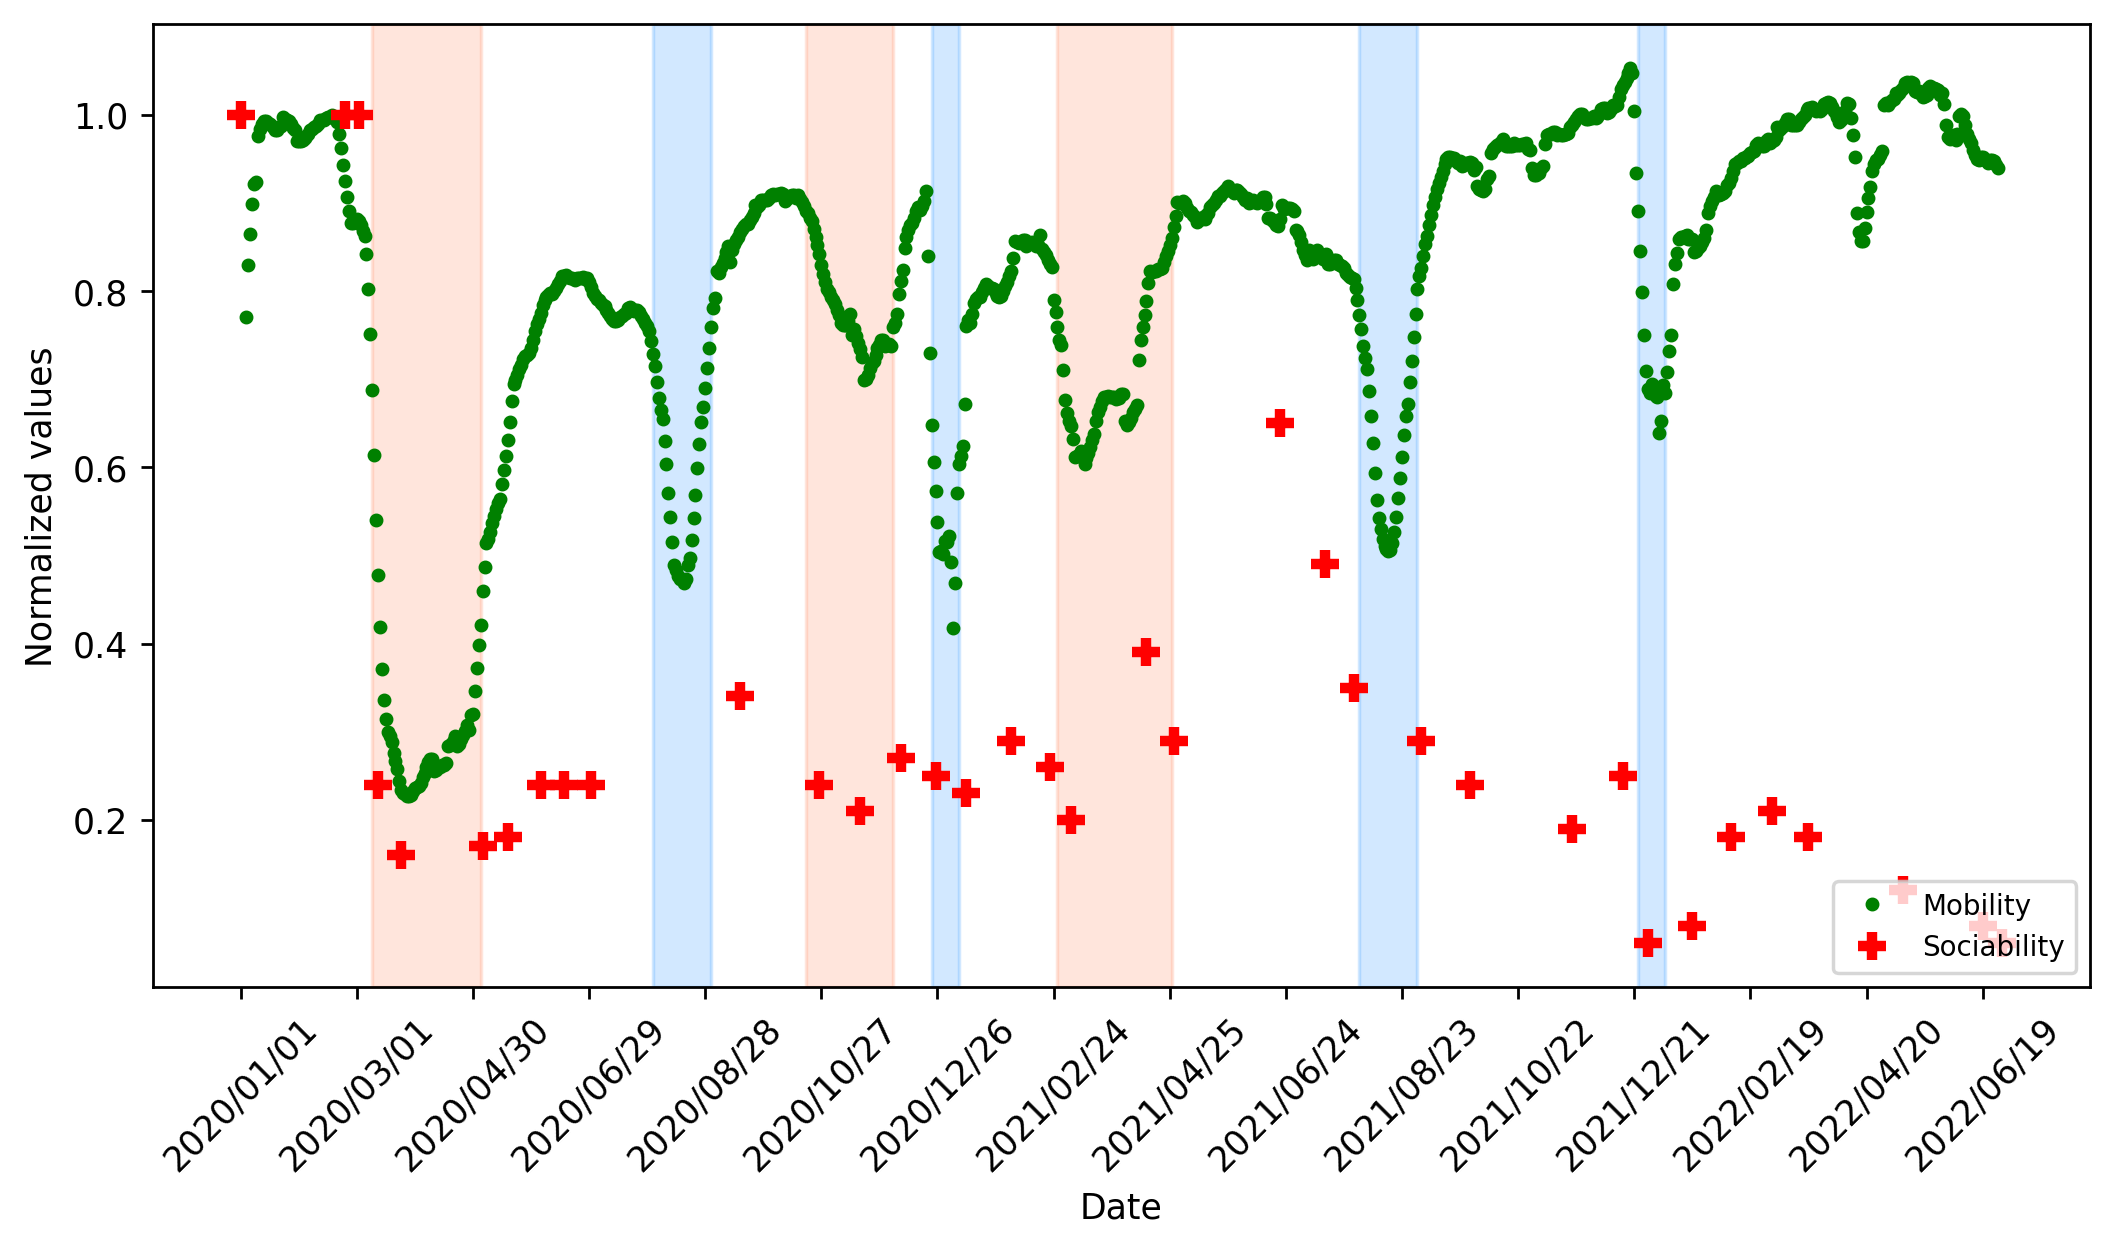

In [5]:

# Plot m_norm and shifted_sociality over time using matplotlib
fig, ax = plt.subplots(figsize=(10,5),dpi=250)
# Plot green dots for m_norm column
ax.plot(df.index, df['m_norm'], 'go', label='Mobility',markersize=3)
# Plot red crosses for shifted_sociality column
ax.plot(df.index, df['sociality'], 'r+', label='Sociability',ms=8,mew=3)

# Draw a different area for each period except the first one
ax.axvspan(pd.to_datetime('2020-03-09'),pd.to_datetime('2020-05-04'),alpha=0.2,color='coral')
ax.axvspan(pd.to_datetime('2020-10-19'),pd.to_datetime('2020-12-03'),alpha=0.2,color='coral')
ax.axvspan(pd.to_datetime('2021-02-26'),pd.to_datetime('2021-04-26'),alpha=0.2,color='coral')

ax.axvspan(pd.to_datetime('2020-08-01'),pd.to_datetime('2020-08-31'),alpha=0.2,color='dodgerblue')
ax.axvspan(pd.to_datetime('2020-12-23'),pd.to_datetime('2021-01-06'),alpha=0.2,color='dodgerblue')
ax.axvspan(pd.to_datetime('2021-08-01'),pd.to_datetime('2021-08-31'),alpha=0.2,color='dodgerblue')
ax.axvspan(pd.to_datetime('2021-12-23'),pd.to_datetime('2022-01-06'),alpha=0.2,color='dodgerblue')

ax.legend(loc='lower right',fontsize=8)


ax.set_xlabel('Date')
ax.set_ylabel('Normalized values')
# Rotate x-axis labels and show only every 10th label
plt.xticks(rotation=45)
ax.xaxis.set_ticks(df.index[::60])
ax.xaxis.set_ticklabels(df.index[::60])
myFmt = mdates.DateFormatter('%Y/%m/%d')
ax.xaxis.set_major_formatter(myFmt)
plt.savefig('figures/mob_socia_norm.pdf',bbox_inches='tight',dpi=300)
plt.show()

### Figure 4b

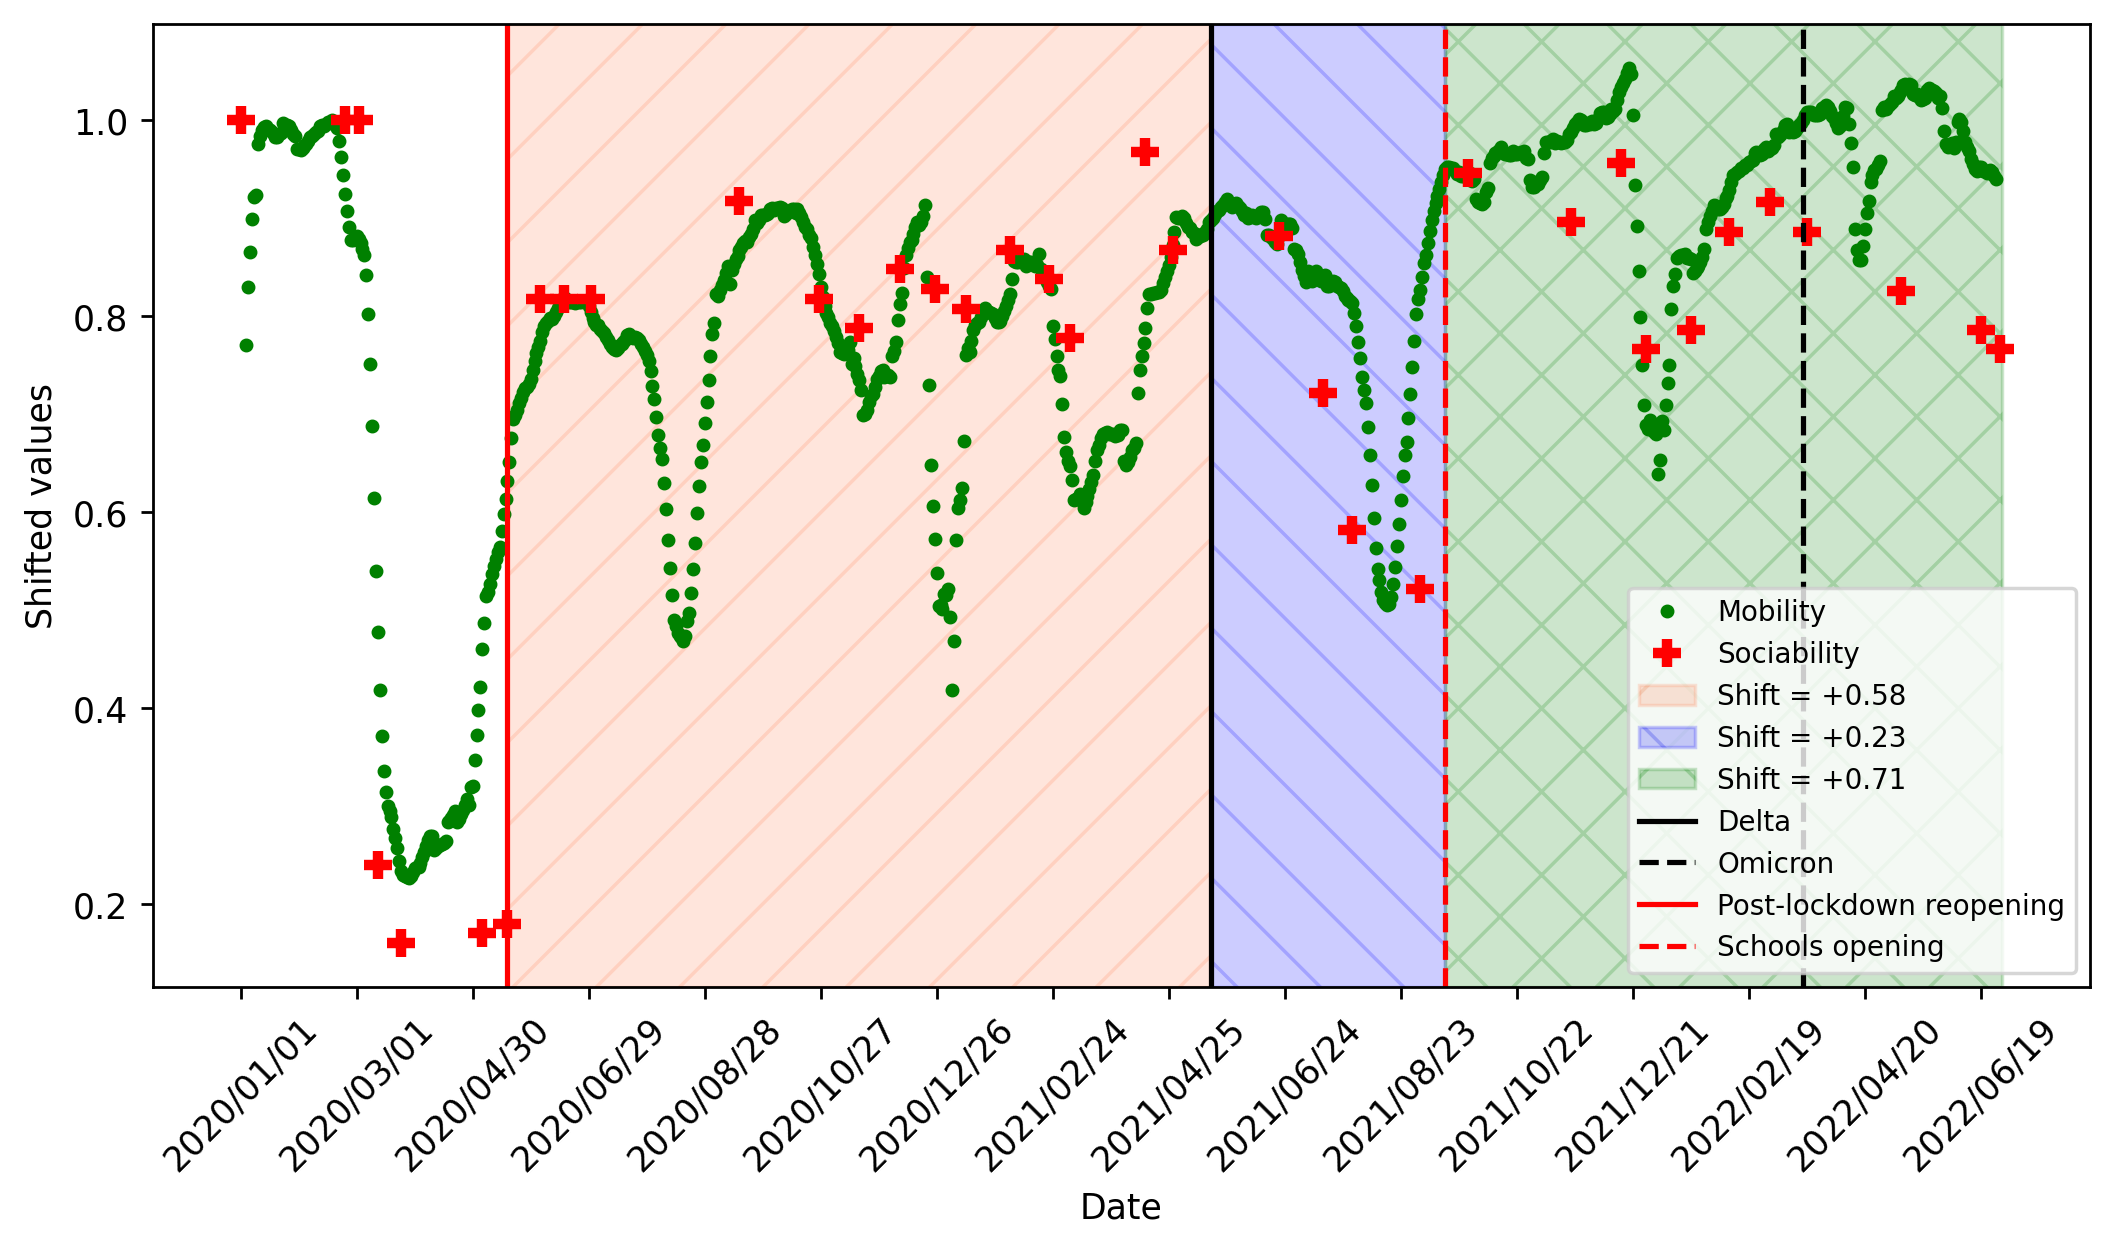

In [6]:

# Plot m_norm and shifted_sociality over time using matplotlib
fig, ax = plt.subplots(figsize=(10,5),dpi=250)
# Plot green dots for m_norm column
ax.plot(df.index, df['m_norm'], 'go', label='Mobility',markersize=3)
# Plot red crosses for shifted_sociality column
ax.plot(df.index, df['shifted_sociality'], 'r+', label='Sociability',ms=8,mew=3)

# Draw a different area for each period except the first one
ax.axvspan(bps[1],bps[2],alpha=0.2,color='coral',hatch='/',label=f'Shift = +{df_shifts.iloc[1]:.2f}')
ax.axvspan(bps[2],bps[3],alpha=0.2,color='blue',hatch='\\',label=f'Shift = +{df_shifts.iloc[2]:.2f}')
ax.axvspan(bps[3],bps[4],alpha=0.2,color='green',hatch='x',label=f'Shift = +{df_shifts.iloc[3]:.2f}')

ax.axvline(pd.to_datetime('2021-05-17'),label='Delta',color='black')
ax.axvline(pd.to_datetime('2022-03-19'),label='Omicron',color='black',linestyle='--')
#ax.axvline(pd.to_datetime('2021-09-01'),label='60% vaccinated',color='black',linestyle='--')
ax.axvline(pd.to_datetime('2020-05-18'),label='Post-lockdown reopening',color='red')
ax.axvline(pd.to_datetime('2021-09-15'),label='Schools opening',color='red',linestyle='--')
ax.legend(loc='lower right',fontsize=8)


ax.set_xlabel('Date')
ax.set_ylabel('Shifted values')
# Rotate x-axis labels and show only every 10th label
plt.xticks(rotation=45)
ax.xaxis.set_ticks(df.index[::60])
ax.xaxis.set_ticklabels(df.index[::60])
myFmt = mdates.DateFormatter('%Y/%m/%d')
ax.xaxis.set_major_formatter(myFmt)
plt.savefig('figures/mob_socia_shift.pdf',bbox_inches='tight',dpi=300)
plt.show()

## Null breakpoint model

In [7]:
# Sample 1000 random sets of 3 indexes from the df

# Number of
nbps=1000
rmses=[]
prs=[]
pvals=[]
for j in range(nbps):
    rbps=list(bps[:1])+sorted(df.iloc[1:-1,:].sample(3).index)+list(bps[-1:])
    df_test=df.copy()
    df_test['sociality']=df_test['sociality'].fillna(method='bfill')
    df_test['m_norm']=df_test['m_norm'].fillna(method='bfill')

    df_test['NPeriod']=pd.cut(df_test.index,bins=rbps,labels=['1','2','3','4'],include_lowest=True)
    temp=df_test.drop_duplicates(subset=['NPeriod'],keep='first')
    temp_shifts=temp['m_norm']-temp['sociality']
    df_test['shifted_sociality']=df_test['sociality']
    for i in range(2,len(bps)):
        df_test.loc[df_test['NPeriod']==str(i),'shifted_sociality']=df_test.loc[df_test['NPeriod']==str(i),'sociality']+temp_shifts.iloc[i-1]

    df_test.dropna(subset=['m_norm','shifted_sociality'],inplace=True)
    # Compute correlation between mobility and sociability
    p,v=stats.pearsonr(df_test['m_norm'],df_test['shifted_sociality'])
    prs.append(p)
    pvals.append(v)
    # Root Mean Square Error in predicting sociability from mobility data
    rmses.append(((df_test["m_norm"]-df_test["shifted_sociality"])**2).mean()**0.5)

In [8]:
# Print max, mean and dev st of Pearson's coefficient of random breakpoints
print(f'Max: {max(prs)}')
print(f'Mean: {sum(prs)/len(prs)}')
print(f'Dev st: {((sum([(x-sum(prs)/len(prs))**2 for x in prs])/len(prs))**0.5)}')


Max: 0.7849590030903192
Mean: 0.4957117837790165
Dev st: 0.15160941625484142


In [9]:
# Print max, mean and dev st of RMSE of random breakpoints
print(f'Min: {min(rmses)}')
print(f'Mean: {sum(rmses)/len(rmses)}')
print(f'Dev st: {((sum([(x-sum(rmses)/len(rmses))**2 for x in rmses])/len(rmses))**0.5)}')


Min: 0.15508860458796214
Mean: 0.3156345231542124
Dev st: 0.0748413266161


## Change-point detection

In [10]:
# Fill m_norm
df['m_norm_full']=df['m_norm'].fillna(method='bfill')
df['m_norm_full']=df['m_norm_full'].fillna(method='ffill')

# Compute difference between sociality and m_norm
df['difference']=df['sociality']-df['m_norm_full']


2020-05-05 00:00:00
2021-06-19 00:00:00
2021-09-27 00:00:00
2022-03-21 00:00:00


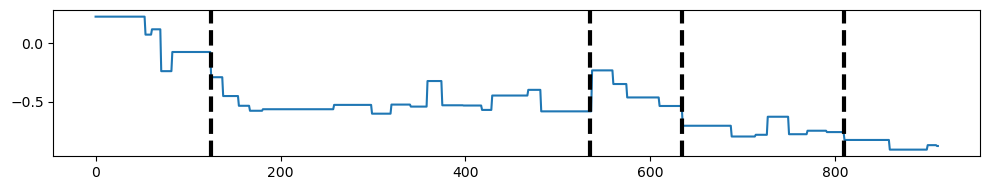

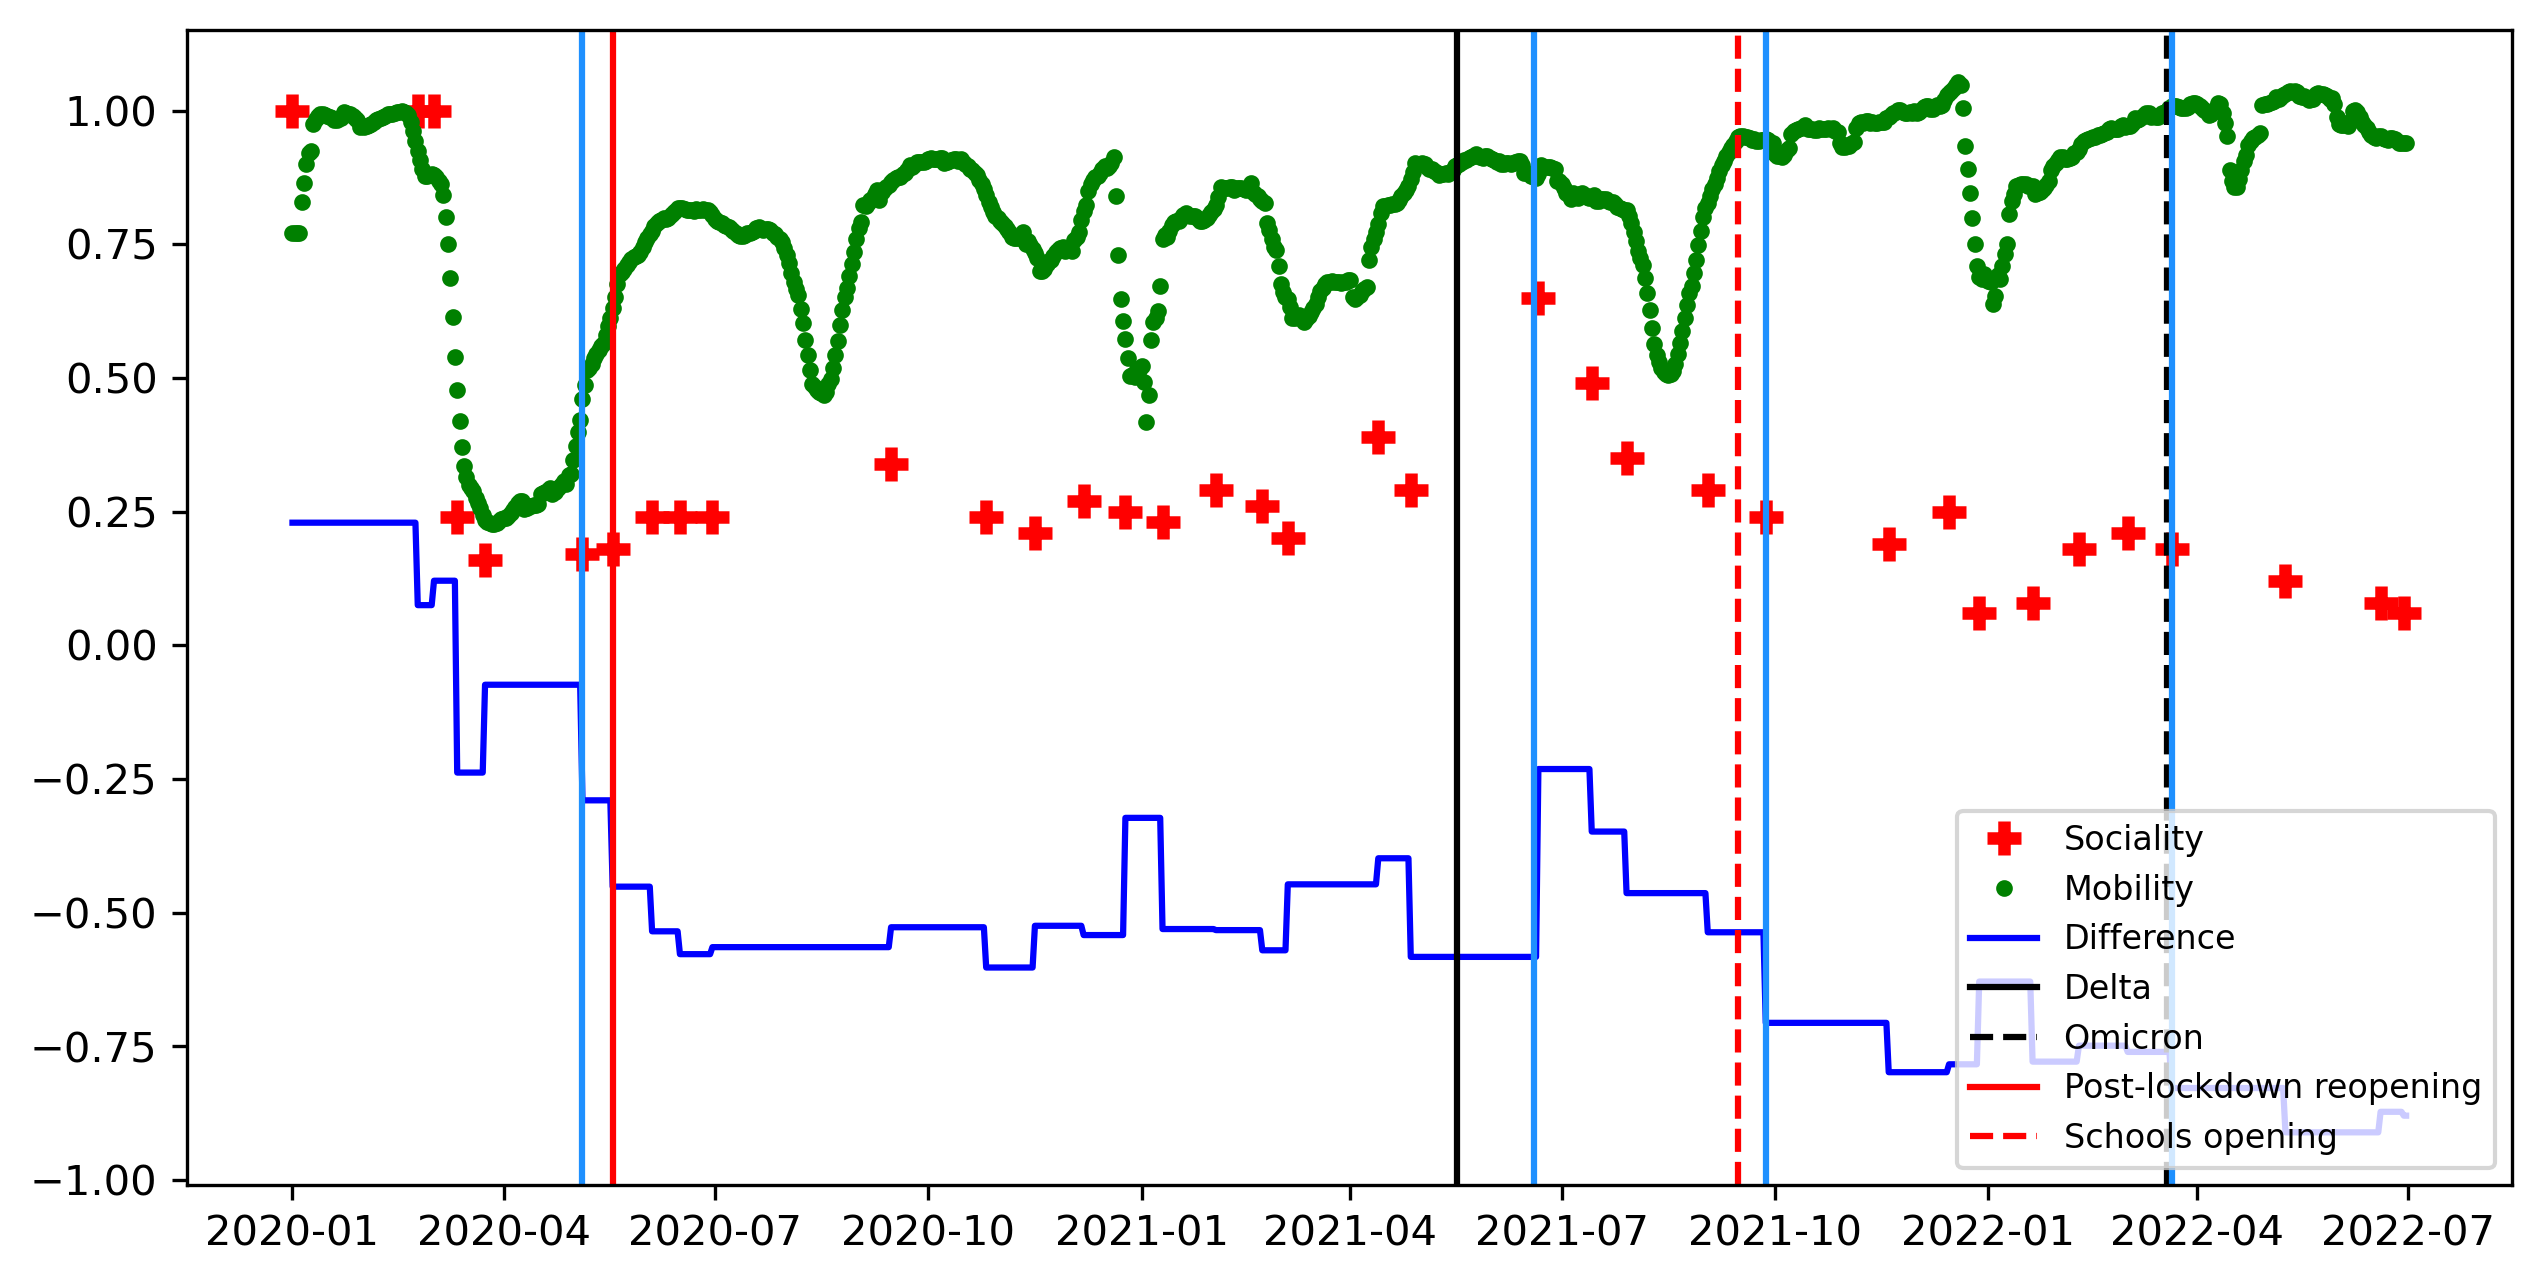

In [11]:
tserie=df['difference'].fillna(method='ffill').values
algo = rpt.Dynp(model="l2", min_size=90)
algo.fit(tserie)
result = algo.predict(n_bkps=4)

rpt.display(tserie, [], result)

df['m_norm_full']=df['m_norm'].fillna(method='bfill')
df['m_norm_full']=df['m_norm_full'].fillna(method='ffill')

# Plot difference between sociality and m_norm
fig, ax = plt.subplots(figsize=(10,5),dpi=300)
# Plot green dots for m_norm column
ax.plot(df.index, df['sociality'], 'r+', label='Sociality',ms=8,mew=3)
ax.plot(df.index, df['m_norm_full'], 'go', label='Mobility',ms=3)
ax.plot(df.index, df['difference'].fillna(method='ffill'), 'b-', label='Difference',markersize=3)

ax.axvline(pd.to_datetime('2021-05-17'),label='Delta',color='black')
ax.axvline(pd.to_datetime('2022-03-19'),label='Omicron',color='black',linestyle='--')
#ax.axvline(pd.to_datetime('2021-09-01'),label='60% vaccinated',color='black',linestyle='--')
ax.axvline(pd.to_datetime('2020-05-18'),label='Post-lockdown reopening',color='red')
ax.axvline(pd.to_datetime('2021-09-15'),label='Schools opening',color='red',linestyle='--')
ax.legend(loc='lower right',fontsize=8)
#plt.legend()
for i in range(0,len(result)-1):
    ax.axvline(df.index[result[i]],color='dodgerblue')
    print(df.index[result[i]])